#### 0. Intro

In this session you will 
- use a classical optimization algorithm called **Simulated Annealing** to minimize binary-quadratic models (free to use in the d-wave package). => Dry run 

- then you will run an actual problem you formulated on on a **[D-wave quantum computer](https://www.dwavesys.com/solutions-and-products/systems/)**!

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import seaborn as sns


from dwave.samplers import SimulatedAnnealingSampler, SteepestDescentSolver # classical free optimizer (installed locally on your computer)
from dwave.system import DWaveSampler, EmbeddingComposite # commercial quantum optimizer (in the cloud)

from dimod import BQM # binary quadratic model object


import numpy as np 
import pandas as pd

#### 1. Exercise

- **Optimize an arbitrary binary-quadratic model** 
    $$ \vec{x}^* = \underset{\vec{x}}{\operatorname{argmin}} \vec{x}Q\vec{x} $$
    **where $Q$ is a random matrix and $\vec{x}^*$ is the minimum-solution vector you are looking for.**

In [2]:
# call the simulated annealing function SimulatedAnnealingSampler(), it will do the optimziation for you
optimizer = SimulatedAnnealingSampler()

In [3]:
# generate a random 2x2 numpy matrix with uniform values between [1,2]
matrix = np.random.uniform(1,2,(2,2))
matrix

array([[1.17958044, 1.16562876],
       [1.41294948, 1.68092808]])

In [4]:
# generate a binary-quadratic model using BQM - don't forget to pass the keyword "BINARY"
bqm = BQM(matrix, 'BINARY')

In [5]:
# minimze the binary-quadratic model with the optimizer.sample() function and use the seed=42
sampleset = optimizer.sample(bqm, seed=42)
print('solution:', sampleset.first.sample)
print('energy:', sampleset.first.energy)

solution: {0: 0, 1: 0}
energy: 0.0


You should have received the trivial solution $\vec{x}^* = [0,0]$ with an energy value of zero (or something smaller than 1e-15 which is close enough).

- **How can you change the values of the matrix such that the minimum solution is NOT the trivial solution?**

In [6]:
# Changing the matrix to get non-trivial results
matrix = -matrix
bqm = BQM(matrix, 'BINARY')
sampleset = optimizer.sample(bqm, seed=42)
print('solution:', sampleset.first.sample)
print('energy:', sampleset.first.energy)

solution: {0: 1, 1: 1}
energy: -5.439086762147083


#### 2. Exercise

The larger the matrix gets, the harder it is to find the minimum solution - this is true for both classical and quantum optimizers. 
- **Make a `for` loop for the matrices ranging from 10x10 to 200x200. The values of the matrix are again uniformly distributed between [1,2]. For each size, run the minimization 100 times with different seeds for the `solver.sample(bqm=bqm, seed=i)` function (where `i` is the index running form 0 to 100).**

In [9]:
# create the described for loop (executing can take up to 25sec)
energies = []
#sizes ranging from 10x10 to 200x200
matrixsizes = np.linspace(10, 200, 20).astype(int)
for matrix in [np.random.uniform(1, 2, (n,n)) for n in matrixsizes]:
    bqm = BQM(matrix, 'BINARY')
    samplesets = [optimizer.sample(bqm,seed=42) for i in range(100)]
    energies.append([sampleset.first.energy for sampleset in samplesets])

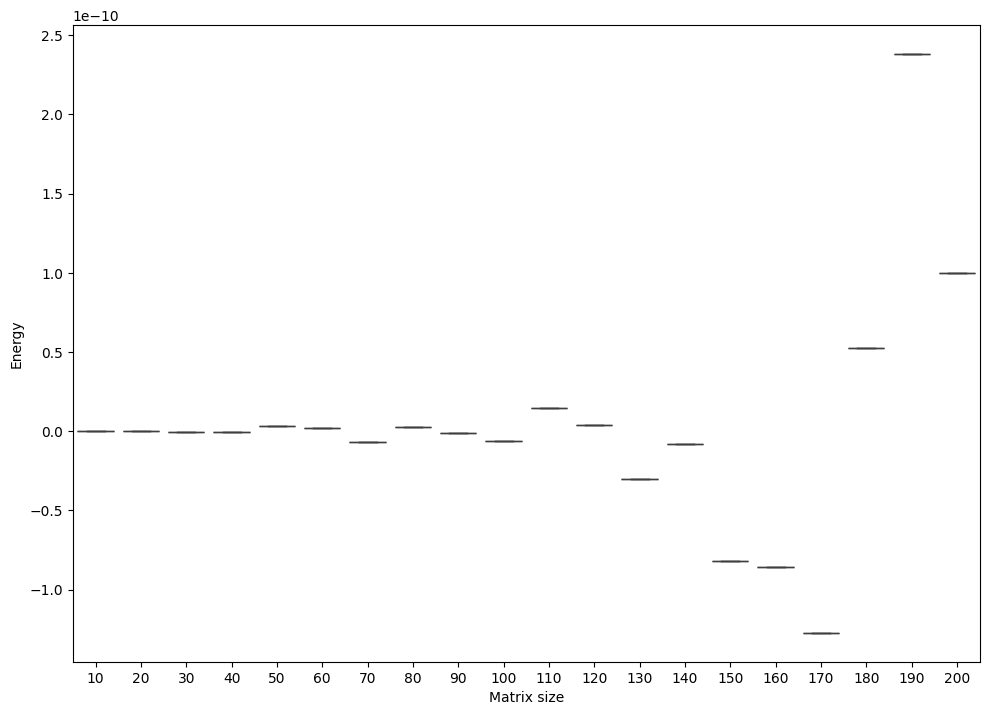

In [10]:
# plotting your solutions
df_plot = pd.DataFrame(energies).T.melt(var_name='trial', value_name='Energy').merge(pd.DataFrame(list(matrixsizes), columns=['Matrix size']), how='left', left_on='trial', right_index=True)
g = sns.boxplot(data=df_plot, x='Matrix size', y='Energy')
plt.gcf().set_size_inches(11.7, 8.27)

- **What is the interpretation of the plot.**

...

- **optional: Redo Exercise 2 but this time with the classical optimization algorithm `SteepestDescentSolver()`. Can you make out differences between the results of simulated annealing and this one?** 

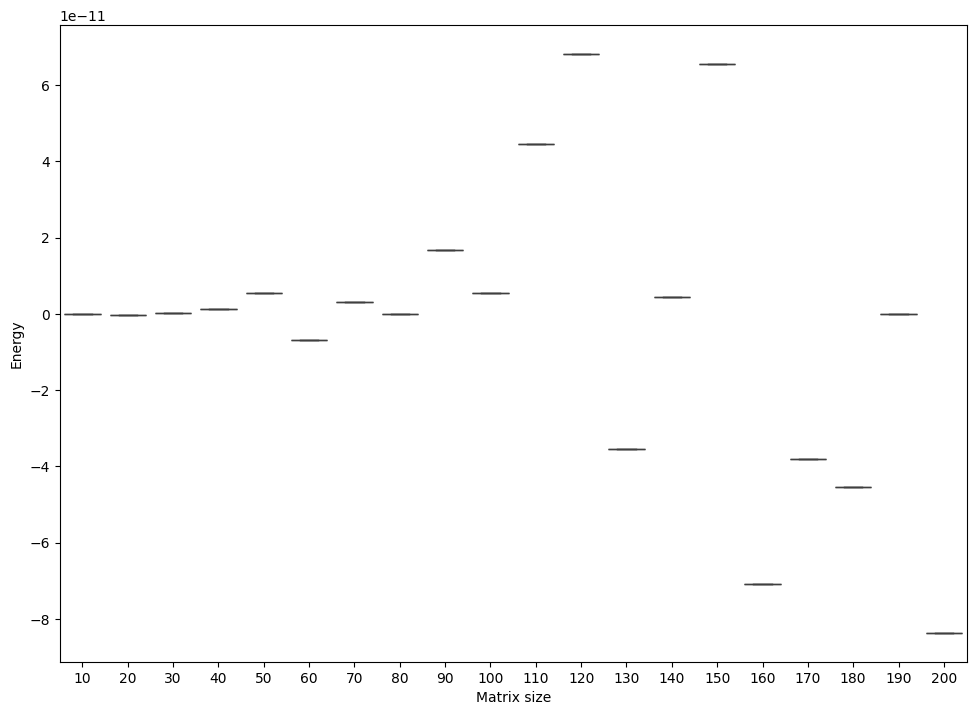

In [11]:
optimizer = SteepestDescentSolver()
# create the described for loop (executing can take up to 25sec)
energies = []
#sizes ranging from 10x10 to 200x200
matrixsizes = np.linspace(10, 200, 20).astype(int)
for matrix in [np.random.uniform(1, 2, (n,n)) for n in matrixsizes]:
    bqm = BQM(matrix, 'BINARY')
    samplesets = [optimizer.sample(bqm,seed=42) for i in range(100)]
    energies.append([sampleset.first.energy for sampleset in samplesets])

# plotting your solutions
df_plot = pd.DataFrame(energies).T.melt(var_name='trial', value_name='Energy').merge(pd.DataFrame(list(matrixsizes), columns=['Matrix size']), how='left', left_on='trial', right_index=True)
g = sns.boxplot(data=df_plot, x='Matrix size', y='Energy')
plt.gcf().set_size_inches(11.7, 8.27)

#### 3. Exercise

**Problem outset**: Today is friday and you want to go out. Naturally, you want to maximize fun but **minimize spending** money on drinks.

You know that the place will offer the following menu of drinks: 

Price in Euro | Drink | Contribution to score 
- 5,40 Long Island Ice Tea 70%
- 5,40 Mochito 60%
- 5,40 Erdbeer Daiquiri 50%
- 3,50 Heineken 35%
- 4,00 Corona 35%
- 4,00 Eristoff Ice 20%
- 3,50 Hugo Spritzer 25%
- 3,00 Cola -2%
- 2,50 Mineralwasser -5%
- 0,00 Leitungswasser -3%

The listed percentages are contributions per drink to your **"drinking score", which must not exceed 100%** (= be reasonably tipsy but avoid a bad hangover).

**The solution** will tell you which drinks to should choose in order to save money and reach (but do not exceed) your drinking score!

**Your turn:**
- (2P) **Assign binary variables**, where for example $x_1=1$ means you drink a Long Island Ice Tea ($x_1=0$ means you do not drink a Long Island Ice Tea).
- (3P) **Define the objective** of the binar model: the objective is to minimize the total sum of euros that you might spend on drinks, e.g.
    $$ 5.4 x_1 + 4x_4 + 3.5x_6 + 3x_7 + 2.5 x_8 $$ 
- (3P) **Add the equality constraint**: you do not want to exceed your drinking limit, so the percentages of your chosen drinks should add up to your drinking score, e.g.
    $$ 70 x_1 + 35x_4 + 25x_6 - 2x_7 - 2x_8 = 100$$
- (2P) **Find the minimum solution** using the **quantum computer** and explain!

In [12]:
# the menu is provided here as pandas.DataFrame
menu = pd.DataFrame({
    'Drink': ['Long Island Ice Tea', 'Mochito', 'Erdbeer Daiquiri', 'Heineken', 'Corona', 'Eristoff Ice', 'Hugo Spritzer', 'Cola', 'Mineralwasser', 'Leitungswasser'],
    'Euro': [5.4, 5.4, 5.4, 3.5, 4, 4, 3.5, 3, 2.5, 0],
    'Score': [70, 60, 50, 35, 35, 20, 25, -2, -5, -2]
})
menu

,Drink,Euro,Score
0,Long Island Ice Tea,5.4,70
1,Mochito,5.4,60
2,Erdbeer Daiquiri,5.4,50
3,Heineken,3.5,35
4,Corona,4.0,35
5,Eristoff Ice,4.0,20
6,Hugo Spritzer,3.5,25
7,Cola,3.0,-2
8,Mineralwasser,2.5,-5
9,Leitungswasser,0.0,-2


In [13]:
# define a binary quadratic model with BQM("BINARY") and use the menu to add the drinks as variables with the according price from the menu. (check the hint below)
bqm = BQM('BINARY')
for drink,euro in zip(menu.Drink, menu.Euro):
    bqm.add_variable(drink, euro)

HINT: use `bqm.add_variable(variable,cost)`

In [19]:
# add a linear the drinking score constraint using bqm.add_linear_equality_constraint() (hint below)
bqm.add_linear_equality_constraint([(drink,score) for drink,score in zip(menu.Drink, menu.Score)],1,-100)

HINT: [check the docs](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generated/dimod.binary.BinaryQuadraticModel.add_linear_equality_constraint.html)

In [20]:
# set the optimization to the dwavve quantum computer (you will need a user account which provides an api token, come to me when you reached this section to get it!)
#optimizer = EmbeddingComposite(DWaveSampler(token='TOKEN')) 
optimizer = SteepestDescentSolver()

In [21]:
sampleset = optimizer.sample(bqm=bqm)
solution = sampleset.first.sample
solution 

{'Cola': 0,
 'Corona': 1,
 'Erdbeer Daiquiri': 0,
 'Eristoff Ice': 0,
 'Heineken': 1,
 'Hugo Spritzer': 1,
 'Leitungswasser': 0,
 'Long Island Ice Tea': 0,
 'Mineralwasser': 0,
 'Mochito': 0}

In [22]:
# get the drinks where the value in the dictionary is 1
drinks_with_value_1 = [drink for drink, value in solution.items() if value == 1]

# filter the DataFrame using isin
result = menu[menu.Drink.isin(drinks_with_value_1)]

In [23]:
# display your dinks of choice
result.Drink

3         Heineken
4           Corona
6    Hugo Spritzer
Name: Drink, dtype: object

In [24]:
# get your spending and score
result.sum()[1:]

Euro     11.0
Score      95
dtype: object

- **optional: Redo the last exercice but this time with the classical optimization algorithm `SteepestDescentSolver()`. Can you make out differences between the results of the quantum annealer and the latter?** 